# Activity Encoding

In [21]:
import pandas as pd
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pickle as pickle

from src.log import Reformat
from src.preprocessing import Encoding

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader

from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import OneHotEncoder

## Visualization

In [22]:
def plot_distance_heatmap(distance, bpi_event_list, celonis_event_list, title):
    data_plot = distance.to_numpy().astype("f")
    data_plot_text = np.around(data_plot, 2).astype(str)
    fig = go.Figure(data=go.Heatmap(z=data_plot,
                                    x=bpi_event_list,
                                    y=celonis_event_list,
                                    text=data_plot_text,
                                    texttemplate="%{text}",
                                    hoverinfo="x+y+z"))
    
    
    fig.update_layout(height=600, width=1200,
                      title="",
                      yaxis_title='Company',
                    xaxis_title='bpi2019',
                      plot_bgcolor='rgba(0,0,0,0)',
                      margin=dict(l=50, r=100, b=30, t=60),
                      legend=dict(x=1, y=0.8,
                                  traceorder="normal",
                                  font=dict(family="sans-serif", size=12, color="black")))
    fig.update_xaxes(tickangle=45)
    fig.update_yaxes(tickangle=-60)
    fig.show()
    return fig

## Load core data set

In [23]:
source_trace = pd.read_pickle("../../Data/Trace/source_trace_c_l.pkl")
target_trace = pd.read_pickle("../../Data/Trace/target_trace_c_l.pkl")

## Get unique activity

In [24]:
source_act = source_trace['Event_Name'].explode('Event_Name').unique()
target_act = target_trace['Event_Name'].explode('Event_Name').unique()

## W2V

### Load model

In [25]:
model_w2v = gensim.downloader.load("glove-wiki-gigaword-50")

### Emcode activity and save

In [28]:
target_act_c = Encoding.remove_abbreviation(target_act)
source_act_c = Encoding.remove_abbreviation(source_act)

embedding_target_w2v = Encoding.embedding_prototype_w2c(target_act_c, model_w2v)
embedding_source_w2v = Encoding.embedding_prototype_w2c(source_act_c, model_w2v)

#Encoding.save_embedding(embedding_target_w2v, target_act, "../../Embedding/embedding_target_w2v.pkl")
#Encoding.save_embedding(embedding_source_w2v, source_act, "../../Embedding/embedding_source_w2v.pkl")

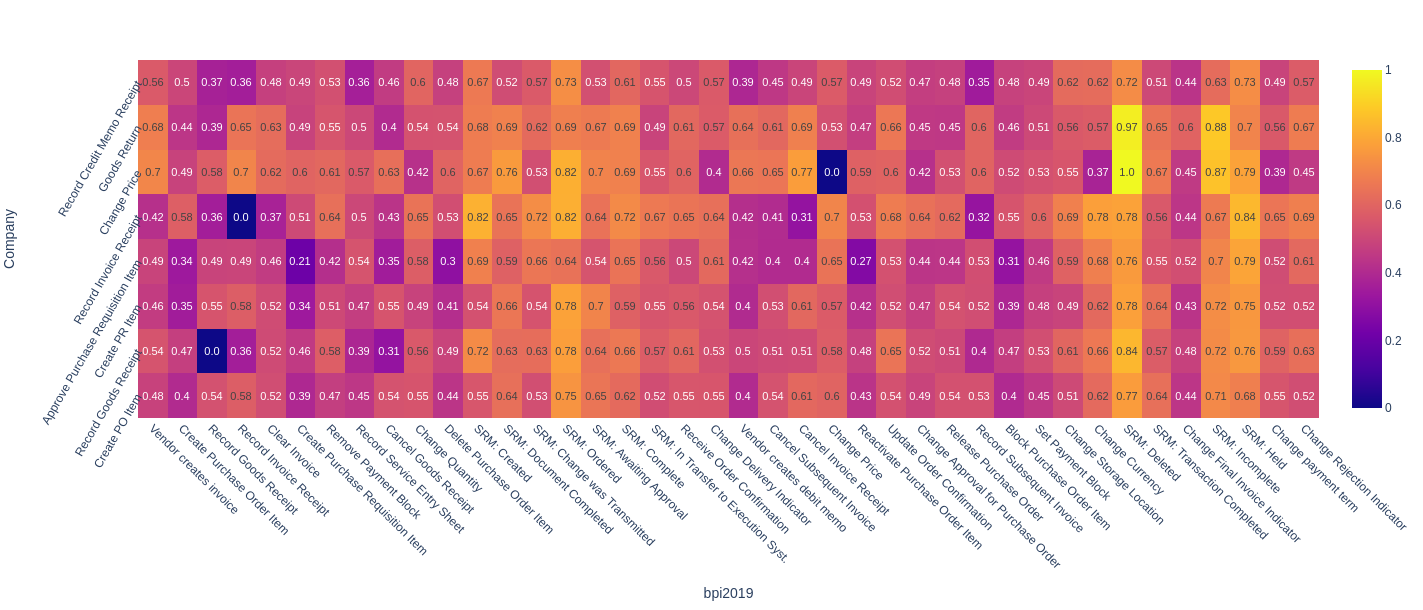

In [29]:
distance_w2v = Encoding.calculate_embedding_distance(embedding_target_w2v, embedding_source_w2v, target_act, source_act)
l2_dis_fig_w2v = plot_distance_heatmap(distance_w2v, target_act, source_act, "L2 distance between event embedding with Word2Vec")

In [39]:
l2_dis_fig_w2v.write_image("../../Result/Fig/L2_Dis_W2V.pdf")

## BERT

### Load model

In [32]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = BertModel.from_pretrained('bert-base-uncased')

In [33]:
embedding_target_bert = Encoding.embedding_prototype_bert(target_act, tokenizer_bert, model_bert)
embedding_source_bert = Encoding.embedding_prototype_bert(source_act, tokenizer_bert, model_bert)

#Encoding.save_embedding(embedding_target_w2v, target_act, "../../Embedding/embedding_target_BERT.pkl")
#Encoding.save_embedding(embedding_source_w2v, source_act, "../../Embedding/embedding_source_BERT.pkl")

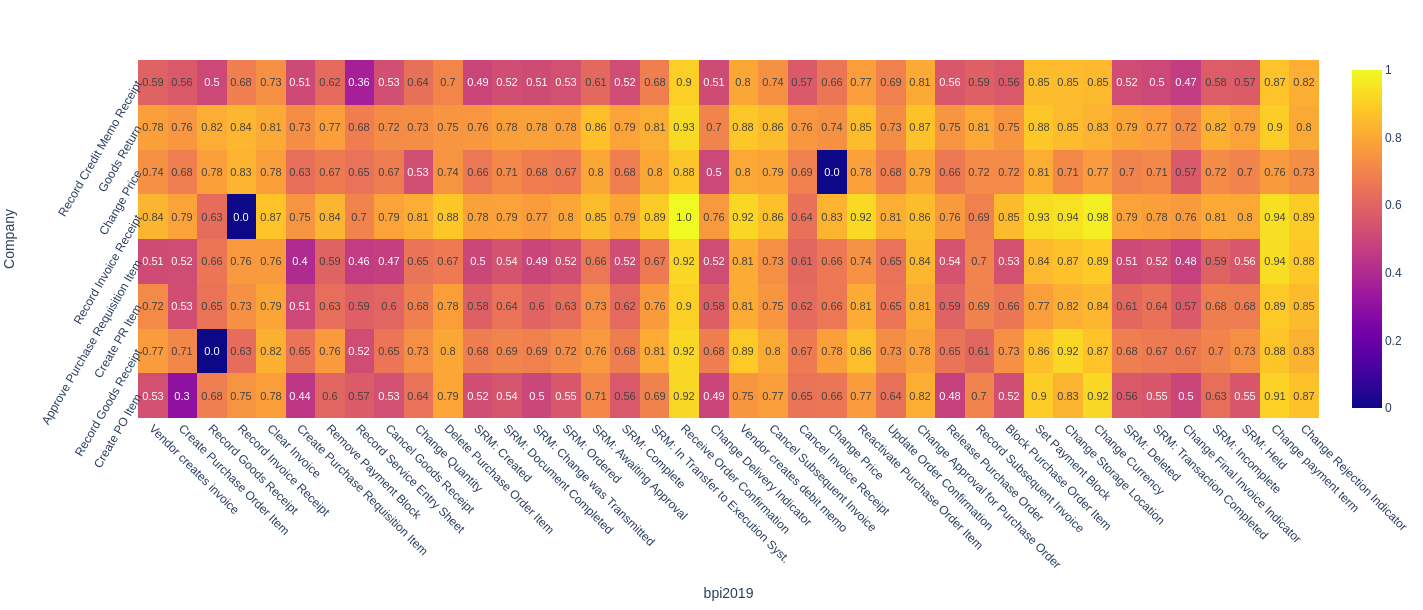

In [34]:
distance_bert = Encoding.calculate_embedding_distance(embedding_target_bert, embedding_source_bert, target_act, source_act)
l2_dis_fig_bert = plot_distance_heatmap(distance_bert, target_act, source_act, "L2 distance between event embedding with BERT")

In [40]:
l2_dis_fig_bert.write_image("../../Result/Fig/L2_Dis_BERT.pdf")

## SentenceBERT

### Create and encode

In [36]:
embedding_target_st = Encoding.embedding_prototype_st(target_act)
embedding_source_st = Encoding.embedding_prototype_st(source_act)

#Encoding.save_embedding(embedding_target_st, target_act, "../../Embedding/embedding_target_st.pkl")
#Encoding.save_embedding(embedding_source_st, source_act, "../../Embedding/embedding_source_st.pkl")

/home/ap43owus/anaconda3/envs/tl4pm/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



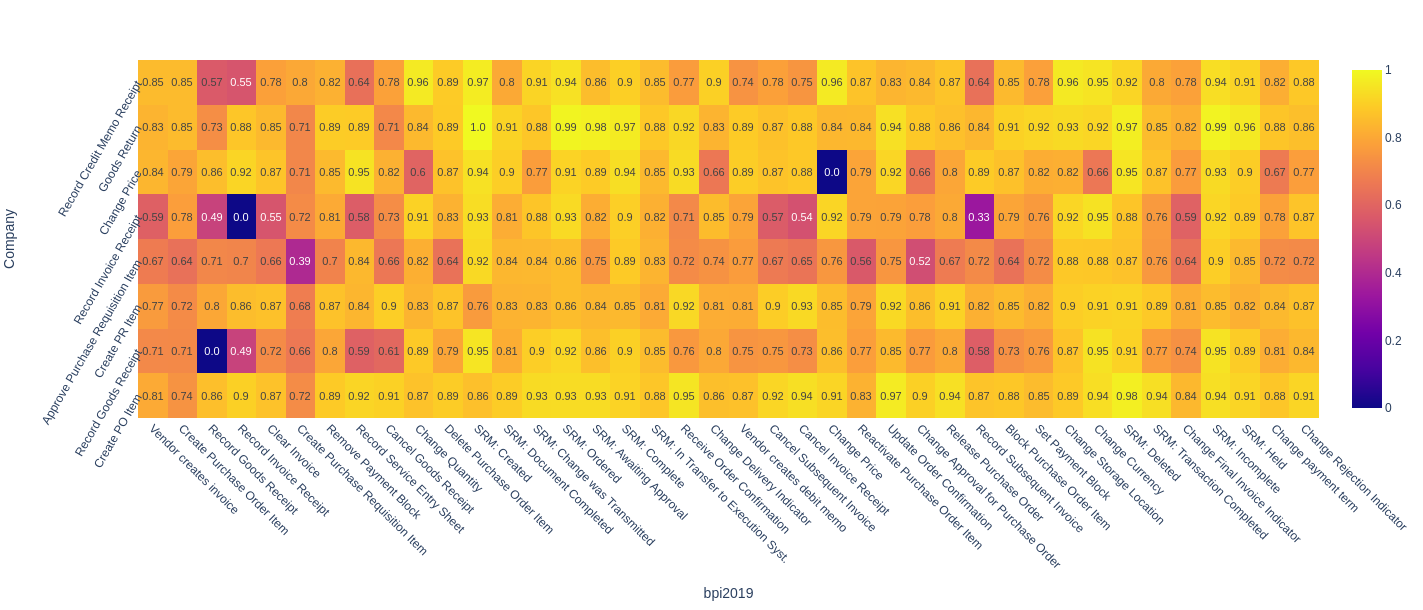

In [37]:
distance_st = Encoding.calculate_embedding_distance(embedding_target_st, embedding_source_st, target_act, source_act)
l2_dis_fig_st = plot_distance_heatmap(distance_st, target_act, source_act, "L2 distance between event embedding with SentenceBERT")

In [41]:
l2_dis_fig_st.write_image("../../Result/Fig/L2_dis_st.pdf")

## One-hot encoding

In [16]:
source_act

array(['Create PR Item', 'Approve Purchase Requisition Item',
       'Create PO Item', 'Record Goods Receipt', 'Goods Return',
       'Record Invoice Receipt', 'Change Price',
       'Record Credit Memo Receipt'], dtype=object)

In [17]:
target_act

array(['Vendor creates invoice', 'Create Purchase Requisition Item',
       'Vendor creates debit memo', 'Create Purchase Order Item',
       'Receive Order Confirmation', 'Change Price', 'Change Quantity',
       'Delete Purchase Order Item', 'SRM: Created',
       'Change Approval for Purchase Order', 'SRM: Ordered',
       'SRM: Change was Transmitted', 'SRM: Document Completed',
       'SRM: Awaiting Approval', 'SRM: Complete',
       'SRM: In Transfer to Execution Syst.', 'Record Goods Receipt',
       'Cancel Goods Receipt', 'Record Service Entry Sheet',
       'Record Invoice Receipt', 'Update Order Confirmation',
       'Remove Payment Block', 'Change Delivery Indicator',
       'Clear Invoice', 'Reactivate Purchase Order Item',
       'Cancel Invoice Receipt', 'Change Storage Location',
       'Block Purchase Order Item', 'Change Currency',
       'Release Purchase Order', 'Cancel Subsequent Invoice',
       'SRM: Deleted', 'SRM: Transaction Completed',
       'Record Subseque

In [27]:
act_union = np.array(list(set(source_act).union(set(target_act))))

In [38]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(act_union.reshape((-1,1)))
embedding_target_onehot = enc.transform(target_act.reshape((-1,1))).toarray()
embedding_source_onehot = enc.transform(source_act.reshape((-1,1))).toarray()

Encoding.save_embedding(embedding_target_onehot, target_act, "../../Embedding/embedding_target_onehot.pkl")
Encoding.save_embedding(embedding_source_onehot, source_act, "../../Embedding/embedding_source_onehot.pkl")